# Deep Q Learning

#### Can I take the findings from Q-Learning, and extend it to a deep learning framework?

In [2]:
# For some reason, importing this first doesn't crash the kernel

import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(0)

In [103]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import deque

# Custom Modules.
from src.modules.game import Game
from src.deep_q.modules import Trainer, Net

from src.deep_q.helpers import update_replay_buffer, play_round, play_games
from src.helpers.plotting import plot_mesh, plot_bar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# Observe distribution of Card Count in several games played.

The module automatically handles reshuffling, so I can just repeat play without re-initializing the module.

I have a "ratio penetrate" flag, which defaults to 2/3 . This means that the deck is reshuffled after it gets through 2/3rds of the deck. I default to 6 deck game as well. You can adjust these values in the Game module.

The distribution of count will be dependent on number of decks used, and ratio penetrate. Although with large ratio penetrate, the distribution might seem a bit misleading. This is because, if there is a large/small count at the point of reshuffling, we neglect the fact that if we play every card (instead of stopping short to reshuffle), the count will converge back to 0 by the end of the deck.

In [5]:
rules = {
    "dealer_hit_soft17": True,
    "push_dealer22": False,
    "double_after_split": True,
    "hit_after_split_aces": False,
    "reduced_blackjack_payout": False,
    "allow_surrender": True,
}

game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}

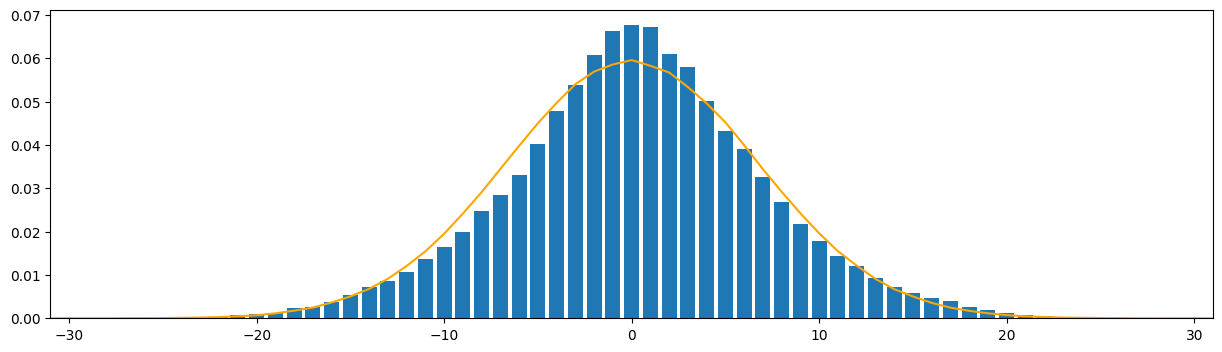

In [6]:
blackjack = Game(**game_hyperparams)
count = []

for _ in range(50_000) :
    
    count.append(blackjack.count)
    
    blackjack.init_round(wagers=[1])
    blackjack.deal_init()
    player = blackjack.players[0] # only 1 player, so i'll just extract that specific player module.
    house_show = blackjack.get_house_show(show_value=True)

    while not player.is_done() :

        player_show,useable_ace = player.get_value()

        policy = player.get_valid_moves()
        policy = [p for p in policy if p!='insurance']

        move = np.random.choice(policy)

        # Gather count after every single move.
        count.append(blackjack.count)

        blackjack.step_player(player,move)
    blackjack.step_house()
    
plt.figure(figsize=(15,4))
inds = np.argsort(pd.Series(count).value_counts(normalize=True).index.to_list())
plt.bar(
    pd.Series(count).value_counts(normalize=True).index[inds],
    pd.Series(count).value_counts(normalize=True).values[inds]
)
samples = np.random.normal(0,np.array(count).std(), 1_000_000)
minmax = max(abs(min(count)), max(count))
a, b = np.histogram(samples, np.arange(-minmax-1.5, minmax+1.5), density=True)
plt.plot([b[i-1:i+1].mean() for i in range(1,b.shape[0])], a, color="orange")
plt.xlim(-minmax, minmax)
plt.show()

## Deep Q Learning


The Q learning without card count is found in my previous notebook. While we determine the Q function explicitly, this requires access to all state-action pairs.

In Deep Q Learning, we are approximating the Q function through use of linear + non-linear layers in a neural network, attempting to minimize MSE between Temporal Difference Q values of current and future states. We will ultimately be regressing the Q value for each possible action for a given state.

As proposed by Deepmind, we make use of a **target network** and a **q network**.

This is because, we are otherwise chasing a non-stationary target in the Q(s,a) values.

Given state $s$, we use the **q network** to compute the $Q(s,a)$ values for each action. At the same time, the **target network** uses the next state $s`$ to compute $Q(s`,a)$ for the TD target. $Q(s`,a)$ doesn't always have meaning, as taking an action in $s$ might lead us to a terminal state. In this instance, we simply look at the reward. After $M$ rounds, we copy the parameters of the **q network** over to the **target network**.
 
We can implement **experience replay**, where we store the agent's past experience in a deque and sample from this during training. So, in each epoch, simulate a round of gameplay, and store the following:
$$(state, possible_actions, action, reward, done, new_state, possible_actions_new)$$
The state, aka model inputs, are represented as:
$$(player_total, house_shows, useable_ace, can_split, first_move)$$
Typically, you'll see $(state, action, reward, done, new_state)$, without the possible actions. However, in my module (and blackjack environment in practice), not every action is possible in a given state.


### Action Masking
I want a way to implement action masking. I need this because not every action is accessible from every state. I can try this 2 different ways:
- Explicitly mask outputs based on state
- Implicitly learn this mask by heavily penalizing outcomes that select an invalid action.


#### Explicit Masking
My first attempt at handling this is by explicitly doing action masking for both **target network** and **q network**, where I have access to possible actions, and I can mask invalid ones by forcing model outputs to $-inf$. This will have the impact that in both $argmax$ and $softmax$, they will be unreachable actions and will never be used for $Q(s`,a)$ or $Q(s,a)$ action selections. Until I find a better method for this, I don't particularly like it. $Q(s,a)$ values for unreachable states are quite high even for unreachable states, and it seems to pull from the actual meaningful $Q(s,a)$ values for valid states.


#### Implicit Masking
My next approach is to implicitly penalize selections to invalid states. Given that $can_split, first_move$ are parts of the input space, the network should feasibly be able to differentiate when it can and cannot split + double. In the replay buffer, if we select an invalid action, we immediately stop gameplay simulation and add a response with a reward of $-3$ units, to heavily penalize when this happens. I can tinker with the reward value itself, as $-3$ might be too drastic during learning.

In [8]:
REPLAY_SIZE = 10_000
MIN_REPLAY_SIZE = 1_000 # this won't be hit exactly due to splitting.
GAMMA = 0.99
LR = 0.0001
TARGET_UPDATE_FREQ = 1_000
N_EPOCHS = 500_000
EVAL_EVERY = 10_000
BATCH_SIZE = 32

EPS_MIN = .1
EPS_DECAY = - np.log(EPS_MIN) / (N_EPOCHS * 0.75)

In [9]:
class Net(nn.Module):

    def __init__(self, input_dim, layer_1, layer_2) :
        super().__init__()
                
        self.moves = ["stay", "hit", "double", "split"]

        self.fc_input = nn.Linear(input_dim, layer_1)
        self.fc_hidden_1 = nn.Linear(layer_1, layer_2)
        self.fc_output = nn.Linear(layer_2, len(self.moves))

    def mask(self, valid_moves):
        """
        inputs:
        - valid_moves: (batch_size, n_moves_i)

        outputs:
        - (batch_size, n_moves)
        """

        def to_mask(moves):
            return [1 if (move in moves) else torch.nan for move in self.moves]

        return torch.tensor(list(map(to_mask, valid_moves)))

        
    def forward(self, data) :
        """
        inputs:
        - data: (batch_size, input_dim)

        outputs:
        - (batch_size, output_dim)
        """
        
        x_t = F.relu(self.fc_input(data))
        x_t = F.relu(self.fc_hidden_1(x_t))
        return self.fc_output(x_t)
    

    def act(self, obs, method="argmax", avail_actions=[]):
        """
        inputs:
        - obs: (batch_size, 5)
        - avail_actions: empty or (batch_size, n_i)

        returns: 
        - q_avail_t: (batch_size, 5)
        - q_selection_t: (batch_size, 1)
        - actions_t: (batch_size, 1)
        """

        assert method in ["argmax", "softmax"], "must use a valid method"

        with torch.no_grad():
            q_values_t = self.forward(obs)

            q_avail_t = q_values_t.detach()

            if avail_actions:
                mask_t = self.mask(avail_actions)
                q_avail_t = torch.nan_to_num(q_avail_t * mask_t, nan=-torch.inf)

            if method == "argmax":
                actions_t = torch.argmax(q_avail_t, dim=1, keepdim=True)
            else:
                action_p = F.softmax(q_avail_t, dim=1).numpy()
                actions_t = torch.tensor(list(map(lambda x : np.random.choice(x.shape[0], p=x), action_p))).unsqueeze(-1)

            q_selection_t = q_avail_t.gather(1, index=actions_t)

        return q_avail_t, q_selection_t, actions_t

In [10]:
hidden_layers = [25,25]

online_net = Net(5, layer_1=hidden_layers[0], layer_2=hidden_layers[1])
target_net = Net(5, layer_1=hidden_layers[0], layer_2=hidden_layers[1])

target_net.load_state_dict(online_net.state_dict())

loss_fct = nn.SmoothL1Loss()
optimizer = torch.optim.Adam(online_net.parameters(), lr=LR)

replay_buffer = deque([],maxlen=REPLAY_SIZE)
blackjack = Game(**game_hyperparams)

In [11]:
def train_epoch():

    transition_inds = np.random.choice(len(replay_buffer), BATCH_SIZE, replace=True)

    obs_t = torch.tensor([replay_buffer[i][0] for i in transition_inds], dtype=torch.float32)
    a_s = [replay_buffer[i][1] for i in transition_inds]
    moves_t = torch.tensor([online_net.moves.index(replay_buffer[i][2]) for i in transition_inds], dtype=torch.int64).unsqueeze(-1)
    rewards_t = torch.tensor([replay_buffer[i][3] for i in transition_inds], dtype=torch.float32).unsqueeze(-1)
    dones_t = torch.tensor([replay_buffer[i][4] for i in transition_inds], dtype=torch.float32).unsqueeze(-1)
    obs_next_t = torch.tensor([replay_buffer[i][5] or (0,0,0,0,0) for i in transition_inds], dtype=torch.float32)
    a_s_next = [replay_buffer[i][6] or ["stay"] for i in transition_inds]

    online_net.train()

    with torch.no_grad():
        # _, target_q_argmax, _ = target_net.act(obs_next_t, method="argmax", avail_actions=a_s_next)
        _, target_q_argmax, _ = target_net.act(obs_next_t, method="argmax")
        targets = rewards_t + torch.nan_to_num(GAMMA * (1 - dones_t) * target_q_argmax, nan=0)

    q_values = online_net.forward(obs_t)
    action_q_values = q_values.gather(1, moves_t)
    
    loss = loss_fct(action_q_values, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()


async def eval(n_games: int, n_rounds: int, wagers):

    online_net.eval()

    r = await play_games(
        model=online_net,
        n_games=n_games,
        n_rounds=n_rounds,
        wagers=wagers,
        game_hyperparams=game_hyperparams
    )
    mean_reward = np.mean(r[:,0,:])

    return mean_reward

def copy_online_to_target():
    target_net.load_state_dict(online_net.state_dict())

In [12]:
mean_rewards = []
training_loss = []

replay_sufficient = False

for step in range(N_EPOCHS):
    print(f"Round {step}", end="\r")

    eps = max(EPS_MIN, np.exp(-EPS_DECAY * step))

    if not replay_sufficient:
        replay_sufficient = len(replay_buffer) >= MIN_REPLAY_SIZE

    if not replay_sufficient:
        mode = "random"
    else:
        mode = "random" if np.random.sample() < eps else "argmax"
        mode = "softmax"


    update_replay_buffer(
        blackjack=blackjack,
        buffer=replay_buffer,
        model=online_net,
        mode=mode
    )

    if not replay_sufficient: continue

    loss_epoch = train_epoch()

    training_loss.append(loss_epoch)

    if not step % TARGET_UPDATE_FREQ:
        copy_online_to_target()

    if (not step % EVAL_EVERY) or (step + 1 == N_EPOCHS):
        mean_reward = await eval(
            n_games=500,
            n_rounds=50,
            wagers=[1]
        )
        mean_rewards.append(mean_reward)
        print(f"step {step}\
 ---- mean reward per round {mean_reward:.4f}\
 ---- epoch training loss {loss_epoch:.4f}\
 ---- eps {eps:.4f}")

network = Net(5, layer_1=hidden_layers[0], layer_2=hidden_layers[1])

network.load_state_dict(online_net.state_dict())
network.eval()

step 10000 ---- mean reward per round -0.0598 ---- epoch training loss 0.3223 ---- eps 0.9404
step 20000 ---- mean reward per round -0.0528 ---- epoch training loss 0.3578 ---- eps 0.8844
step 30000 ---- mean reward per round -0.0496 ---- epoch training loss 0.3009 ---- eps 0.8318
step 40000 ---- mean reward per round -0.0376 ---- epoch training loss 0.2764 ---- eps 0.7822
step 50000 ---- mean reward per round -0.0483 ---- epoch training loss 0.4698 ---- eps 0.7356
step 60000 ---- mean reward per round -0.0542 ---- epoch training loss 0.3370 ---- eps 0.6918
step 70000 ---- mean reward per round -0.0475 ---- epoch training loss 0.4113 ---- eps 0.6506
step 80000 ---- mean reward per round -0.0514 ---- epoch training loss 0.3606 ---- eps 0.6119
step 90000 ---- mean reward per round -0.0409 ---- epoch training loss 0.4328 ---- eps 0.5754
step 100000 ---- mean reward per round -0.0523 ---- epoch training loss 0.2946 ---- eps 0.5412
step 110000 ---- mean reward per round -0.0464 ---- epoch t

<All keys matched successfully>

In [16]:
# torch.save(network, "./models/deep_q.pt")

In [ ]:
network = Net(5, layer_1=hidden_layers[0], layer_2=hidden_layers[1])
network.load_state_dict(torch.load("./models/deep_a.pt"))
network.eval()

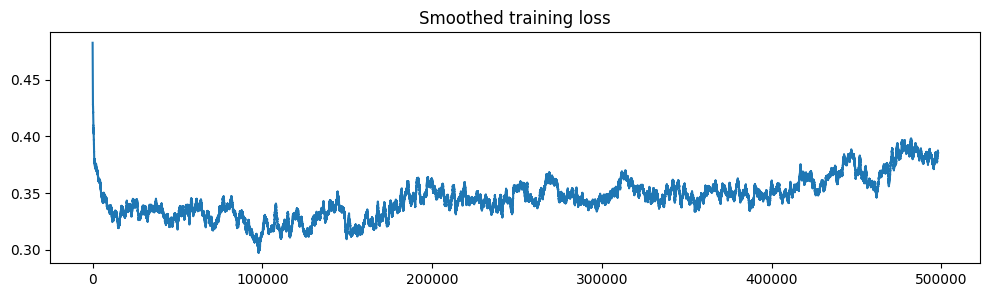

In [17]:
plt.figure(figsize=(12,3))
plt.plot(np.convolve(training_loss, np.ones(1000)/1000, mode="valid"))
plt.title("Smoothed training loss")
# plt.vlines(range(len(training_loss))[::1000], ymin=.25, ymax=.55)
plt.show()

In [18]:
all_states = []

for player in range(4, 22):
    for house in range(2, 12):
        for ace in [-1, 1]:
            if (player < 12) and (ace > 0): continue
            if (player == 21) and (ace > 0): continue
            for split in [-1, 1]:
                if (player == 4) and (split < 0): continue
                if (player == 12) and (split < 0) and (ace > 0): continue
                if (player > 12) and (not player % 2) and (split > 0) and (ace > 0): continue
                if (player % 2) and (split > 0): continue
                for double in [-1, 1]:
                    if (split > 0) and (double < 0): continue
                    if (player == 5) and (double < 0): continue
                    all_states.append((player, house, ace, split, double))

In [19]:
value_det = np.zeros((3, 21+1, 11+1))

online_net.eval()

no_ace_no_split = list(filter(lambda x : (x[2] < 0) and (x[3] < 0) and (x[-1] > 0), all_states))
yes_ace_no_split = list(filter(lambda x : (x[2] > 0) and (x[3] < 0) and (x[-1] > 0), all_states))
yes_split = list(filter(lambda x : (x[3] > 0), all_states))

_, q_values_max, _ = online_net.act(
    torch.tensor(no_ace_no_split, dtype=torch.float32),
    method="argmax",
    avail_actions=[["stay", "hit", "double"] for _ in no_ace_no_split]
)
for i,q in enumerate(q_values_max):
    value_det[0, no_ace_no_split[i][0], no_ace_no_split[i][1]] = q


_, q_values_max, _ = online_net.act(
    torch.tensor(yes_ace_no_split, dtype=torch.float32),
    method="argmax",
    avail_actions=[["stay", "hit", "double"] for _ in yes_ace_no_split]
)
for i,q in enumerate(q_values_max):
    value_det[1, yes_ace_no_split[i][0], yes_ace_no_split[i][1]] = q


_, q_values_max, _ = online_net.act(
    torch.tensor(yes_split, dtype=torch.float32),
    method="argmax",
    avail_actions=[["stay", "hit", "double", "split"] for _ in yes_split]
)
for i,q in enumerate(q_values_max):
    player_ind = int(yes_split[i][0] / 2)
    if player_ind == 6:
        if yes_split[i][2]:
            player_ind = 11
    value_det[2, player_ind, yes_split[i][1]] = q

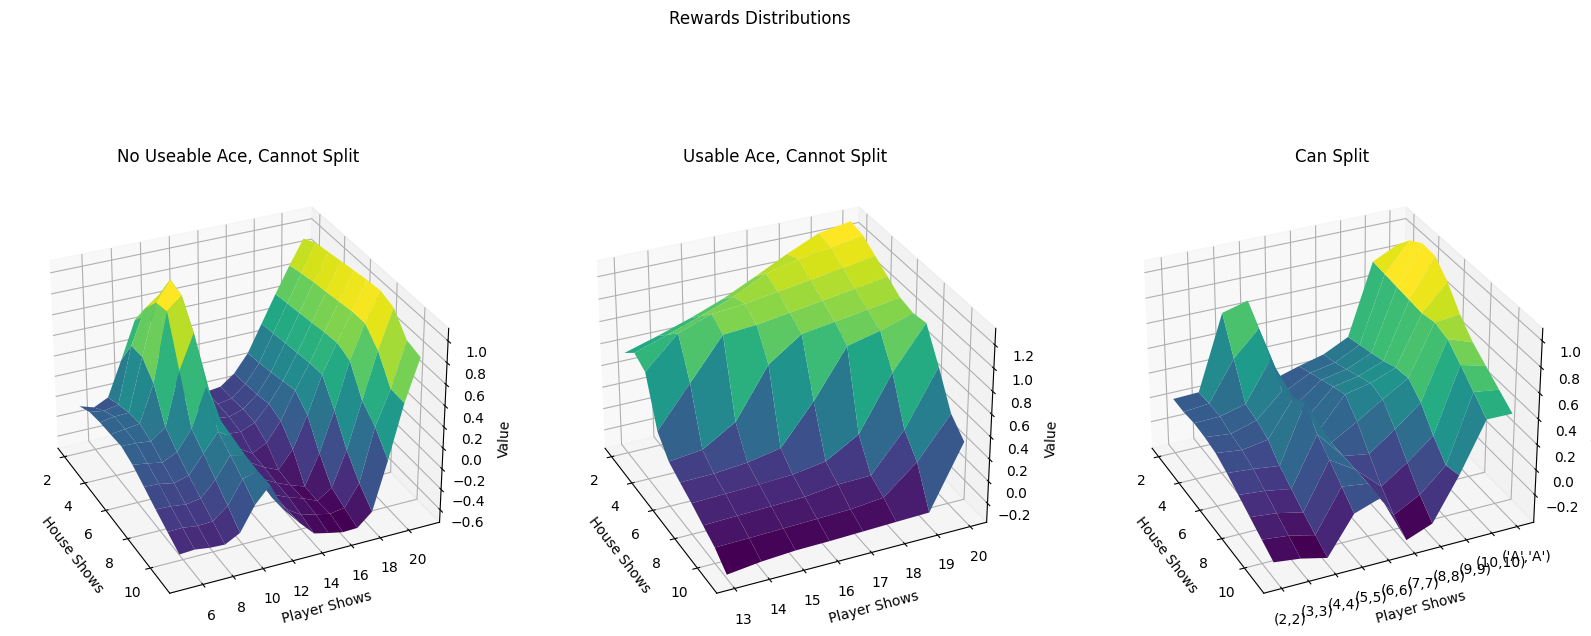

In [20]:
fig = plt.figure(figsize=(20,8))
fig.suptitle("Rewards Distributions")
ax = fig.add_subplot(131, projection="3d")
ax.set_title("No Useable Ace, Cannot Split")

plot_mesh(ax, value_det[0][5:,2:], [range(2,12),range(5,22)], ticks=None)

ax = fig.add_subplot(132, projection="3d")
ax.set_title("Usable Ace, Cannot Split")

plot_mesh(ax, value_det[1][13:21,2:], [range(2,12),range(13,21)], ticks=None)

ax = fig.add_subplot(133, projection="3d")
ax.set_title("Can Split")

ticks = [f"({p},{p})" if p < 11 else "('A','A')" for p in range(2,12)]
plot_mesh(ax, value_det[2][2:12,2:], [range(2,12),range(2,12)], ticks=ticks)

plt.subplots_adjust(hspace=0, wspace=0.2)
plt.show()

In [21]:
blackjack = Game(**game_hyperparams)

network.eval()

r = await play_games(
    model=network,
    n_games=250,
    n_rounds=100,
    wagers=[1],
    game_hyperparams=game_hyperparams
)


In [22]:
np.mean(r[:,0,:])

-0.06552